In [1]:
#Libraries for Model Visualization
from comet_ml import Experiment

In [2]:
experiment = Experiment(api_key="MHehhbanm9HbbvXptMjQ0hinn",
    project_name="tweet-sentiment-analysis",
    workspace="jessica-njuguna")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/jessica-njuguna/tweet-sentiment-analysis/6212d04f6fcc4f09b63d89c916547ecb



# Climate Change Analysis Belief 2022
© Explore Data Science Academy

_Prepared by:_
- Jessica Njuguna
- Stanley Agbo
- Uchenna Unigwe
- Hunadi Mawela
- Teddy Waweru

## Introduction

Living things are dependent on particular conditions to survive. Humans are not exempt from this. Having the right temperature, sufficient water, clean air, and enough food are among the basic requirements for survival. The majority of these requirements depend on the stability of climate change. Climate change refers to shifts in the weather and temperature patterns. Human activity and natural occurrences contribute to climate change.

Since the 1800s, human cultures have been the main drivers of climate change. With increased deforestation, combustion of fossil fuels and increased livestock farming, the concentration of greenhouse gases has increased. These gases cause a greenhouse effect by trapping the sun's heat and escalating global warming.

Warmer temperatures change weather patterns disrupting the natural conditions of the earth. These disruptions harm our environment, degrading the quality of the Earth's air and water. In a bid to cool the earth and reduce the rate of climate change, global organizations are campaigning for more environmentally friendly products and practices. 

### Problem Statement

In the 21st Century, more companies build their brand with the consideration of **lessened environmental impact** or **carbon footprint**. Thus, their operations products and services are inclined to being more **environmentally friendly** and sustainable, in line with their values and ideals. <br>
To improve market research on their products/services, we developed the folowing **ML project** that intends to determine how people **perceive climate change**, and _whether or not they believe it is a real threat_. <br>

We believe this would provide a **metric** on how companies' products/service may be **received by the public**. Providing a robust ML solution will enable our clients to **access to a broad base of consumer sentiment**, spanning multiple demographic and geographic categories - thus **increasing their insights and informing future marketing strategies**.<br>

To build our **predictive model** for the project, we utilized a dataset of **collected tweet data** to determine if a person believes in climate data or _not_.


### Table of Contents

[Introduction](#introduction)
- Problem Statement
- Table of Contents
- Summary
    - Agenda
    - Deliverables
    - Results
    - Future Considerations
- Preliminary Activities
    - Importing Packages
    - Loading the Datasets
    
[Exploratory Data Analysis](#exploratory_data_analysis)
- Functions Declaration
- Statistical Summaries
    - Train Dataset
    - Test Dataset
- Visualizations

[Data Engineering](#data_engineering)
- Functions Declaration
- Dealing with Null Values
- Splitting features
- Dummy Variables
- Data Scaling
- Feature Selection

[Modelling](#modelling)
- Functions Declaration
- RandomForest Classification
    - Introduction #
    - Model Development
    - Model Performance Metrics
    - Test Dataset Prediction Metrics
- XG Boost Classification
    - Model Development
    - Model Performance Metrics
    - Test Dataset Prediction Metrics
- Hyper Parameter Tuning

[Model Performance Comparison](#model_performance_comparison)


[Model Explanation](#model_explanation)

[Conclusion](#conclusion)

[Appendix](#appendix)
- Kaggle Submission
    - Functions Declaration
    - Submission Metrics




    






### _Summary_

**Agenda:**

**Deliverables:**

**Results:**

**Future Considerations:**

### Preliminary Activities

#### Importing Packages

In [1]:
# Libraries for data loading, data manipulation
import pandas as pd
import numpy as np

#Libraries for Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 1)
from wordcloud import WordCloud
from statsmodels.graphics.correlation import plot_corr

#Libraries to clean the text
import contractions #This expands contraction such as 'don't' to 'do not'
import regex as re
import string
import nltk
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import emoji #allows us to manipulate with emojis
import itertools


#Libraries for test pre-processing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer


# Libraries for data preparation
# import statsmodels.formula.api as sm
# from statsmodels.formula.api import ols
# from scipy.stats import pearsonr
# from statsmodels.distributions.empirical_distribution import ECDF       #Imported for displaying the Empirical Cumulative Distribution of Features
# from sklearn.feature_selection import SelectKBest, f_regression

# Libraries for model building
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.tree import DecisionTreeRegressor

#Libraries for Model Performance
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.tree import plot_tree
# from sklearn.model_selection import GridSearchCV

# Libraries for mathematical analyses
import numpy as np


#Library for creating pickle files of the models
import pickle

# Setting global constants to ensure notebook results are reproducible
# PARAMETER_CONSTANT = ###

#### Loading the datasets

In [2]:
#load the datasets in raw_df
raw_train_df = pd.read_csv('resources/data/train.csv')
raw_test_df = pd.read_csv('resources/data/test.csv')

## Exploratory Data Analysis

Exploratory Data Analysis(EDA) refers to investigating the data in its raw form to spot anomalies, discover patterns and check for assumptions using summary statistics. 

Preliminary checks of the EDA might include:

1. Columns in the data
2. Number of observations in the data
3. Presence of missing values in the data
4. Presence of duplicates
5. Type of data in the columns; numerical(discrete, continuous), categorical or time
6. Presence of outliers/uncommon observations

The patterns existing in the dataset can be displayed using graphs and visuals. To outline the patterns, we look at:
- Patterns in the individual columns (univariate analysis)
- Patterns between columns (multivariate analysis)

Analysis of the patterns allows us to test hypotheses that can give us insight into the topic the data covers. Going through the EDA process is necessary because it highlights the steps for preparing the data for prediction modelling.

### Functions Declaration

This section defines functions that will be used for the EDA section.

In [5]:
### We declare the functions that we can call later within the project development

#The function below takes a string and expands all contractions in the string


### Statistical Summaries

#A00

Statistical Summaries are used to communicate information about large datasets by summarizing the set of observations. 

They can be measures of central tendancy (mean, mode), distribution (skewness and kurtosis) and relationship (correlation). The features of the dataset in this project is expected to be text data. Therefore, the summaries that will be covered are mode and mean. Mode refers to the most frequent object, in this case words. The anomalies covered are the null values and the duplicates.

#### Train Dataset

We have loaded two datasets: train and test. This section explores the train dataframe. Thereafter, we will explore the test dataframe

First, we make a copy of the train dataset. Any manipulations on the data frame does not have an effect on the raw train_df. 

In [3]:
#Set deep as True to copy both the indices and data of the df
train_df = raw_train_df.copy(deep = True)

Next, we view the first five columns of the dataset. This gives us an overview of the columns and a preview of the rows

In [4]:
train_df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


From the first five rows we see that the train df contains three columns containing the tweet in the message column, the sentiment in numerical figures and the tweetid.

Sometimes, data is inappriately stored and can cause issues when performing analysis. Therefore, we check the data type of the columns using .info 

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


The sentiment and tweetid column are stored as integers and the message is stored as string. These data types match the contents in the column. 

Given that the message is as string, we will have to convert it to numerical format in the feature engineering section. This will be done using vectorization. Vectorization takes the words in the columns and assigns them a numerical figure based on calculations on its frequency in the column.

Next, we inspect the number of observations in the dataframe. This allows us to see how many values we will be working with in the modelling phase.

In [6]:
train_df.shape

(15819, 3)

The dataset contains 15,819 observations. Observations above 30 are considered as best practice for modelling.

Now that we have general information about the dataset, we look at our target variable. 

The sentiments are our target variable, using value_counts we see the different categories of sentiments and their corresponding number of observations and visualize with a bar graph

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

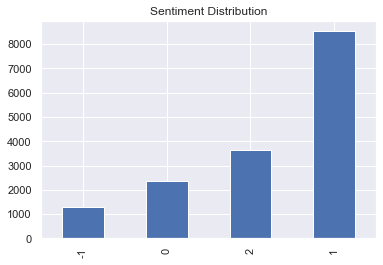

In [8]:
train_df['sentiment'].value_counts(ascending = True).plot(kind = 'bar', title = 'Sentiment Distribution')
train_df['sentiment'].value_counts()

As seen above, the sentiment column has four unique integers. From our variable description, we derive the following meanings for each category:
- 2 News: the tweet links to factual news about climate change
- 1 Pro: the tweet supports the belief of man-made climate change
- 0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change
- -1 Anti: the tweet does not believe in man-made climate change

From the cell above, we see that Pro sentiments are the highest in the dataset with 8,530 observations. The Anti The sentiments are lowest with 1,296 obseravations. 

Therefore, our data has more information about Pro sentiments than it does about Anti sentiments. This is a representation gap that is reffered to as _imbalanced dataset_. Due to the insufficient information we have about the lower frequency sentiments,  the learning capability of our model is compromised.

In the feature engineering section, we will fix this by randomly selecting examples from the minority sentiments and adding them to the dataframe with replacement.


##### Duplicates

Incorrect duplicates affect the learning capability of the model. It is an anomally that gives conflicting information to the model. For this reason, we check for incorrect duplicates in the data to remove them in the Feature Engineering section. We are only concerned with the incorrect duplicates because we have a imbalanced dataset as highlighted above. The correct duplicates will remain in the dataset.

For this classification problem, each unique observation should have its own sentiment. That is, one tweet can not have two sentiments. Failure to which, the observation will be dropped.

We first check if there are duplicates in the tweet_id column using .unique()


In [12]:
#Inspecting the tweetid column
len(train_df['tweetid'].unique())

15819

The unique values of the tweetid column are equal to the number of observations in the dataset. Therefore, they are unique identifies to the tweets and there are no duplicate values.

We can now check if all the tweets are unique.

In [13]:
#Checking the number of unique values

len(train_df['message'].unique())

14229

There are 14,229 unique tweets which is less than the number of rows in the dataset. This is an indication of duplicated tweets in the dataset.

We get the exact number of duplicates in the message column by checking the shape of duplicated messages.

In [14]:
dupli = train_df[train_df.duplicated(['message'])]
dupli['sentiment'].value_counts()

 1    1308
 0     109
 2      98
-1      75
Name: sentiment, dtype: int64

<AxesSubplot:title={'center':'Sentiment Distribution'}>

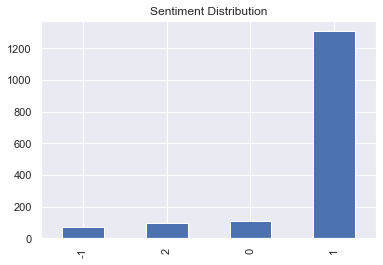

In [15]:
dupli['sentiment'].value_counts(ascending = True).plot(kind = 'bar', title = 'Sentiment Distribution')

The Pro sentiments have the highest number of duplicates and also the highest number of observations in the dataset. To assist with imbalancing, the duplicates for the Pro sentiments in the Feature Engineering section.

The duplicated tweets are 1,590. This is quite a number.
We are only interested in the tweets are similar but have been classified opposing each other. We check this by grouping the tweets and counting the unique sentiments of the grouped tweet. If a tweet has more than one unique sentiment, we conclude that it is an incorrect duplicate

In [16]:
duplicates = train_df.groupby('message').filter(lambda x: len(x['sentiment'].unique()) > 1)
print(duplicates)
for index,text in enumerate(duplicates['message']):
    print('Review %d:\n'%(index+1),text)

       sentiment                                            message  tweetid
258           -1  RT @Uniocracy: They'll tell you theyre doing i...   529327
2390           2  RT @Channel4News: .@LeoDiCaprio calls on citiz...   460524
5393           0  RT @Uniocracy: They'll tell you theyre doing i...   723133
8446           0  RT @realDonaldTrump: Where the hell is global ...   228082
9141           0  RT @COP22: In 4 days the most ambitious climat...   407156
10351          1  RT @Channel4News: .@LeoDiCaprio calls on citiz...    93815
12001         -1  RT @realDonaldTrump: Where the hell is global ...   663534
14103          1  RT @COP22: In 4 days the most ambitious climat...   357058
Review 1:
 RT @Uniocracy: They'll tell you theyre doing it to save you from global warming. Theyre lying https://t.co/PRFpiM7pyj #OpChemtrails
Review 2:
 RT @Channel4News: .@LeoDiCaprio calls on citizens to vote for Ã¢â‚¬Å“people who believe in climate changeÃ¢â‚¬ï†; @realDonaldTrump has called itÃ¢â‚¬Â¦


Out of the duplicated observations, 8 of them are not equal in sentiment. These give us confilicting information about the relationship betweeen the tweet and the sentiment. These rows will be dropped in the feature engineering section. 

In [17]:
train_df.isna().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

There are no null values in the dataset. Therefore, no imputation will be perfomed on the data set. With these checks done, we can step into our main feature, the tweets.

#### Tweet Sampling

In this segment, we step into the tweets. We take a sample and view what it contains. One way to investigate this is through wordclouds.
Wordclouds are graphical representations of word frequency. It gives priority to more frequent words, and displays them with different font sizes. More frequent words appear larger than the less frequent words.

Generating the word cloud, gives us insight to what is prominent in each sentiment represented. We will also view the anomolies in the tweets that will be cleaned in the Feature Engineering section.

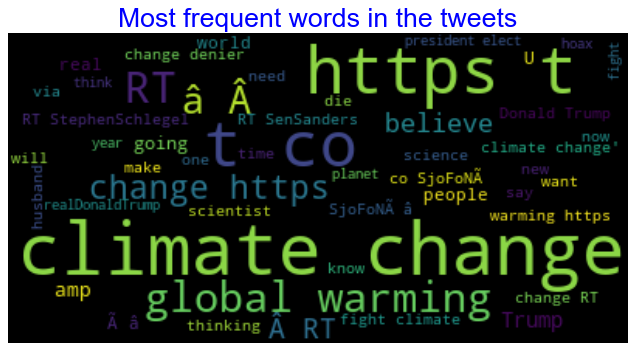

In [28]:
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="black").generate(' '.join(train_df['message']))
plt.figure(figsize=(10,6), dpi=80)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Most frequent words in the tweets', fontsize = 24, color = 'blue')
plt.axis("off")
plt.show()

In [24]:
#We generate a new data frame that joins all the tweets per sentiment

train_grouped=train_df[['sentiment','message']].groupby('sentiment').agg(sum)
train_grouped.head()

,message
sentiment,
-1,Sally Kohn’s latest evidence of climate change...
0,Calum: *tweets abt reunitingish w the cast*\r\...
1,PolySciMajor EPA chief doesn't think carbon di...
2,RT @RawStory: Researchers say we have three ye...


The resulting dataframe has one columns with the concatened tweets and four rows with the sentiments. To ascertain our success, let us sample on of the rows.

In [11]:
#Viewing a row from the grouped dataframe

train_grouped['message'][2]

"RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…RT @tveitdal: We only have a 5 percent chance of avoiding ‘dangerous’ global warming, a study finds https://t.co/xUBTqNxhkK https://t.co/of…Fossil fuel giant ExxonMobil ‘misled’ the public about climate change, Harvard academics conclude https://t.co/ofc2WSu4EXBangladesh confronting climate change head on https://t.co/MTqeNBQDUt https://t.co/itgkUxgEfgRT @latimes: Atmospheric rivers fueled by climate change could decimate wild oysters in San Francisco Bay https://t.co/p0LZBhlU5K https://t…RT @Independent: Trump's team removed climate change data from the White House website. They may be breaking the law…2050 climate targets: nations are playing the long game in fighting global warming https://t.co/dnegw2vfJd via @ConversationEDURT @washingtonpost: The Alaskan tundra is filling the atmosphere with carbon dioxide, worsening climate change https://t.

The third row contains all the tweets of one sentiment. Success! With the grouped data we can now create the wordclouds

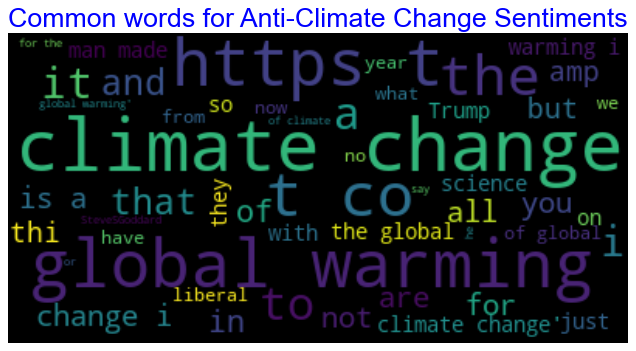

In [21]:
text = train_grouped.iloc[0,0]
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="black").generate_from_text(text)
plt.figure(figsize=(10,6), dpi=80)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Common words for Anti-Climate Change Sentiments', fontsize = 24, color = 'blue')
plt.axis("off")
plt.show()

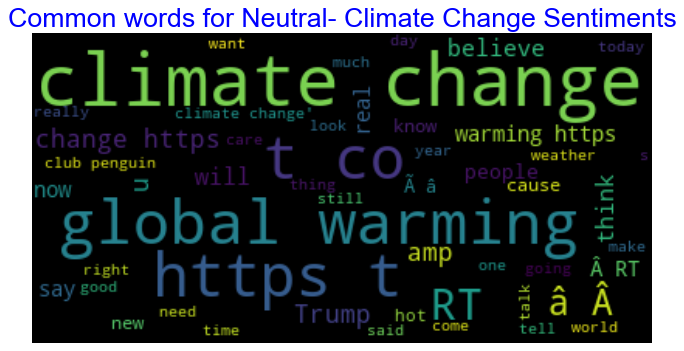

In [25]:
text = train_grouped.iloc[1,0]
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="black").generate_from_text(text)
plt.figure(figsize=(10,6), dpi=80)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Common words for Neutral- Climate Change Sentiments', fontsize = 24, color = 'blue')
plt.axis("off")
plt.show()

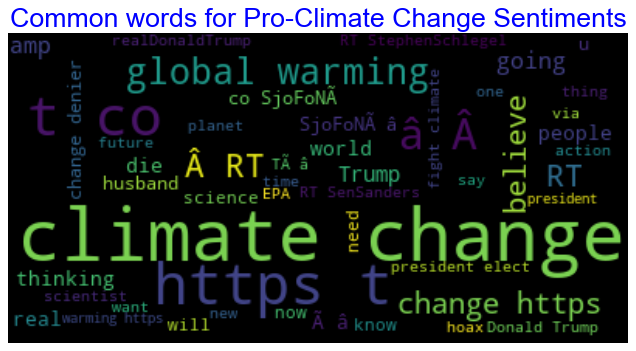

In [26]:
text = train_grouped.iloc[2,0]
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="black").generate_from_text(text)
plt.figure(figsize=(10,6), dpi=80)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Common words for Pro-Climate Change Sentiments', fontsize = 24, color = 'blue')
plt.axis("off")
plt.show()

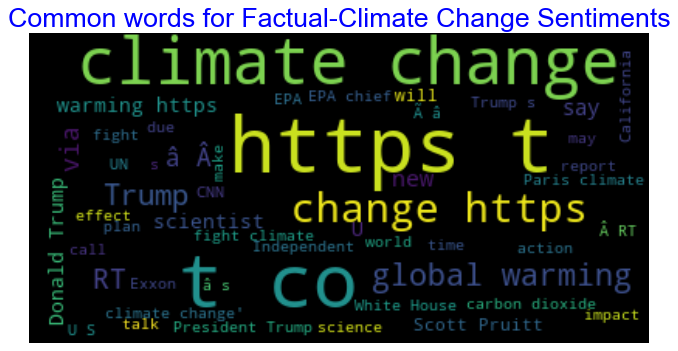

In [27]:
text = train_grouped.iloc[3,0]
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="black").generate_from_text(text)
plt.figure(figsize=(10,6), dpi=80)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Common words for Factual-Climate Change Sentiments', fontsize = 24, color = 'blue')
plt.axis("off")
plt.show()

Sampling the tweets, we see that some contain url's, mentions, and hashtags. These would be cleaned to extract the parts of the tweet that direct us more toward the sentiment in the Feature Engineering section.

Now let us explore the test dataset to inform of the necessary data cleaning concepts to perform.

#### Test Dataset

Similar to the train dataset, we first create a copy

In [19]:
test_df = raw_test_df.copy(deep = True)

We view the first five rows in the dataset

In [20]:
test_df.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \r\nPu...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


Our test dataframe has two columns with the message and tweetid. The target variable, sentiment has been removed.

In [21]:
test_df.shape

(10546, 2)

The models will predict the sentiments of 10,546 tweets

In [22]:
test_df.isna().sum()

message    0
tweetid    0
dtype: int64

There are no null values in the dataframe

In [23]:
len(raw_test_df['tweetid'].unique())

10546

The tweet id acts as our unique identifier with no duplicates in the dataframe

In [24]:
len(test_df['message'].unique())

9575

The message column has duplicates. The code below allows us to get the exact number of duplicates

In [25]:
test_df[test_df.duplicated(['message'])].shape

(971, 2)

In the test dataframe, we have 971 duplicate tweets. During the model prediction, we will test out if the model predicts the same sentiment for the duplicated tweets. This will help us view the accuracy our model has

In [26]:
for index,text in enumerate(raw_test_df['message'][30:35]):
    print('Review %d:\n'%(index+1),text)

Review 1:
 How to green the world's deserts and reverse climate change | Allan Savory https://t.co/lYwtQN6ZlQ via @YouTube
Review 2:
 RT @94kristin: let's talk climate change
Review 3:
 RT @mymodernmet: Photographer @thevonwong raises awareness for victims of climate change with epic shoot on a bed of lavaÃ¢â‚¬Â¦
Review 4:
 RT @SteveSGoddard: No matter how much Democrats scream and lie and protest and spread their hatred, the global warming scam will always be…
Review 5:
 RT @TIME: An entire Canadian river vanished due to climate change, researchers say https://t.co/gS6h3j6c9g


The tweets contain URL's and mentions. Before predicting, we will clean the data just as we have for the train data set

## Data Engineering

### Functions Declaration

In [27]:
def expand_contractions(text):
    #takes the text
    expanded = contractions.fix(text)
    #returns expanded text
    return expanded

# Function to drop links from text using regex to replace the link with a comma
def strip_links(text):
    #define the regex formula to find urls
    link_regex = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    #finds all the links in the text
    links = re.findall(link_regex, text)
    #iterates over all the links
    for link in links:
        #replace the link with a comma
        text = text.replace(link[0], ', ')
        #retuns the text without links
    return text

# Function to drop mentions from text
def strip_mentions(text):
    #Twitter mentions start with '@', we create a list with that character
    strip_sign = ['@']
    
    #for separator in  string.punctuation:
        #if separator not in strip_sign :
            #text = text.replace(separator,' ')
    # we create an empty list
    words = []
    #Iterate over each word in the text
    for word in text.split():
        #remove all leading spaces and trailing spaces in the word
        word = word.strip()
        if word:
            #check if the first character of the word is not '@'
            if word[0] not in strip_sign:
                #if False it appends the word to the list words
                words.append(word)
    #returns the text as string with all mentions removed
    return ' '.join(words)

#Function to Lemmatize the words
'''
Lemmatization is the process of reducing a variation of a word to
it's root word. For example; cooking to cook or adventurous to adventure
'''
#Create a function lemmatizer from WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def tweet_lemma(text, lemmatizer):
    
    #iterates over each word in the text and lemmatizes it
    return [lemmatizer.lemmatize(t) for t in text]    

#Function to remove stop_words
def remove_stop_words(text):
    #iterates over each word in the text
    #appends only words that are not in the english stopwords list
    return [t for t in text if t not in stopwords.words('english')]

#Function to remove emojis
def remove_emojis(text):
    #iterates over each object in the text
    #appends the objects that are not in the emoji list
    return [t for t in text if t not in emoji.UNICODE_EMOJI]


tfidf_vectorizer = TfidfVectorizer(stop_words = 'english')
hashing_vectorizer = HashingVectorizer(n_features = 4000)
count_vectorizer = CountVectorizer()

#### Dropping duplicates

In the EDA section, it was noted that the Pro sentiments had the highest duplicates. In the following cell, we drop the duplicates of the Pro sentiments to improve the balance of the data.

In [28]:
train_df_allduplicate = train_df[(train_df['sentiment'] == 1 )& (train_df.duplicated(['message']))]
train_df_noduplicate = train_df_allduplicate.drop_duplicates('message', keep = 'first')
train_df_discduplicate = train_df_allduplicate.drop(index = train_df_noduplicate.index)
train_df = train_df.drop(index = train_df_discduplicate.index)
train_df_discduplicate.sort_values('message')

,sentiment,message,tweetid
9559,1,RT @1followernodad: parent: I'd do anything fo...,853233
11299,1,RT @1followernodad: parent: I'd do anything fo...,133976
12562,1,RT @1followernodad: parent: I'd do anything fo...,187199
15747,1,RT @1followernodad: parent: I'd do anything fo...,783223
11818,1,RT @1followernodad: parent: I'd do anything fo...,345949
...,...,...,...
7723,1,RT @savmontano: Our president doesn't believe ...,107394
5635,1,RT @savmontano: Our president doesn't believe ...,169280
10615,1,RT @voxdotcom: TrumpÃ¢â‚¬â„¢s election marks t...,396891
14128,1,RT @washingtonpost: 'Al Gore offers to work wi...,141082


In [29]:
dupli = train_df[train_df.duplicated(['message'])]
dupli['sentiment'].value_counts()
#dupli[dupli['sentiment'] == 1].sort_values(by = 'message')
#dupli[dupli['message'].str.contains('RT @AJEnglish')].sort_values(by = 'message')

 1    209
 0    109
 2     98
-1     75
Name: sentiment, dtype: int64

### Feature Extraction - In progress

Method features for additional features and look at how it distributes with each sentiment. Plot per class.(use box plot) describe

_1. Tweet Length_ 

This is also referred to as the number of characters in the string

In [30]:
train_df['tweet_len'] = train_df['message'].astype(str).apply(len)
train_df['tweet_len'].mean()

122.59191576086957

_2. Number of sentences_

In [31]:
tokeniser = TreebankWordTokenizer()
train_df['sent_count'] = train_df["message"].apply(lambda x: len(tokeniser.tokenize(x)))
train_df['sent_count'].mean()

22.1640625

_2. Number of words per tweet_ - Unigwe

In [32]:
train_df['word_count'] = train_df["message"].apply(lambda x: len(re.findall(r'\w+', x)))
train_df['word_count'].mean()

20.01032608695652

_3. Number of unique words per tweet_ - Hunadi

In [33]:
train_df['num_unique'] = train_df["message"].apply(lambda x: len(set(x.lower().split())))
train_df['num_unique'].mean()

16.903872282608695

_5. Number of stop words per tweet_ - Stanley

In [34]:
stop_words = set(stopwords.words('english'))
train_df['num_stop_words'] = train_df['message'].str.split().apply(lambda x: len(set(x) & stop_words))

In [35]:
train_df['num_stop_words'].mean()

4.070040760869565

_6. Number of punctuations per tweet_ - Stanley

In [36]:
train_df['num_punctuations'] = train_df["message"].apply(lambda x: len(re.findall(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*', 
                        x)))
train_df['num_punctuations'].head()

0    137
1     63
2    137
3     98
4    123
Name: num_punctuations, dtype: int64

_7. Number of hashtags_

In [37]:
train_df['num_hashtags'] = train_df["message"].apply(lambda x: len(re.findall(r'(#w[A-Za-z0-9]*)', x)))
train_df['num_hashtags'].value_counts()

0    14681
1       38
2        1
Name: num_hashtags, dtype: int64

_8. Number of mentions_

In [38]:
train_df['num_mentions'] = train_df["message"].apply(lambda x: len(re.findall(r'(@w[A-Za-z0-9]*)', x)))
train_df['num_mentions'].value_counts()

0    14507
1      213
Name: num_mentions, dtype: int64

_9. Number of words in UpperCase_

In [39]:
train_df['num_uppercase'] = train_df["message"].apply(lambda x:sum(map(str.isupper,x.split())))
train_df['num_uppercase'].mean()

1.0319972826086956

### Cleaning the text data - Done, Markdowns left

Introductory paragraph

Unstructured data is about 90% in different formats, describe the formats. The extra features are called noise. 

To further explore the data, we will clean the text by performing the following steps:

1. Expand contractions
2. Remove digits and words containing digits
3. Lower the message
4. Remove punctuation
5. Stemming and Lemmetazition
6. Vectorization

The cleaned tweets will be stored in a new column 'cleaned_message' to manage errors

_1. Spelling corrections_ - Jessica

from spellchecker import SpellChecker
train_df['message'] = train_df['message'].apply(lambda txt:SpellChecker().correction(txt))

_2. Remove digits and words containing digits_

In [40]:
train_df['message']=train_df['message'].apply(lambda x: re.sub('\w*\d\w*','', x))
train_df['message'].head()

0    PolySciMajor EPA chief doesn't think carbon di...
1    It's not like we lack evidence of anthropogeni...
2    RT @RawStory: Researchers say we have three ye...
3    #TodayinMaker# WIRED :  was a pivotal year in ...
4    RT @SoyNovioDeTodas: It's , and a racist, sexi...
Name: message, dtype: object

_3. Expanding contractions_

In [41]:
train_df['message']=train_df['message'].apply(lambda x:expand_contractions(x))
train_df['message'][0:5]

0    PolySciMajor EPA chief does not think carbon d...
1    It is not like we lack evidence of anthropogen...
2    RT @RawStory: Researchers say we have three ye...
3    #TodayinMaker# WIRED :  was a pivotal year in ...
4    RT @SoyNovioDeTodas: It is , and a racist, sex...
Name: message, dtype: object

_3. Lowercase all the tweets_

In [42]:
train_df['message']=train_df['message'].apply(lambda x: x.lower())
train_df['message'][0:5]

0    polyscimajor epa chief does not think carbon d...
1    it is not like we lack evidence of anthropogen...
2    rt @rawstory: researchers say we have three ye...
3    #todayinmaker# wired :  was a pivotal year in ...
4    rt @soynoviodetodas: it is , and a racist, sex...
Name: message, dtype: object

_4. Removing punctuation_

In [43]:
train_df['message']=train_df['message'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
train_df['message'][0:5]

0    polyscimajor epa chief does not think carbon d...
1    it is not like we lack evidence of anthropogen...
2    rt rawstory researchers say we have three year...
3    todayinmaker wired   was a pivotal year in the...
4    rt soynoviodetodas it is  and a racist sexist ...
Name: message, dtype: object

_4. Stemming and Lemmatization_

In [44]:
tokeniser = TreebankWordTokenizer()
lemmatizer = WordNetLemmatizer()
snowball = SnowballStemmer('english')

def lemmer(words):
    token_words = TreebankWordTokenizer().tokenize(words)
    lem_sentence=[]
    for word in token_words:
        #just lemmmatize
        #stem_word = snowball.stem(word)
        lem_word = lemmatizer.lemmatize(word)
        lem_sentence.append(lem_word)
        lem_sentence.append(" ")
    return "".join(lem_sentence)

train_df['message'] = train_df['message'].apply(lemmer) 
train_df['message'].head()


0    polyscimajor epa chief doe not think carbon di...
1    it is not like we lack evidence of anthropogen...
2    rt rawstory researcher say we have three year ...
3    todayinmaker wired wa a pivotal year in the wa...
4    rt soynoviodetodas it is and a racist sexist c...
Name: message, dtype: object

_Splitting the data set_

In [45]:
X = train_df.drop(columns = ['tweetid', 'sentiment'], axis = 1)
y = train_df['sentiment']
list(X.columns)

['message',
 'tweet_len',
 'sent_count',
 'word_count',
 'num_unique',
 'num_stop_words',
 'num_punctuations',
 'num_hashtags',
 'num_mentions',
 'num_uppercase']

_Vectorizing the data set_

In [47]:
text =train_df.message
# text
tfidf_vectorizer.fit(text)

X['vect_tweet'] = list(tfidf_vectorizer.transform(X['message']).toarray())

# tfidf_X_train_df = pd.DataFrame(tfidf_feat)

# columns = ['num_hashtags','num_punctuations','num_mentions','num_uppercase', 'num_unique']

# Vectorized_train = pd.merge(tfidf_X_train_df,X[columns],left_index=True, right_index=True)

print('TF-IDF Vector Shape: \t {}'.format(len(tfidf_vectorizer.get_feature_names_out())))


MemoryError: Unable to allocate 2.52 GiB for an array with shape (14720, 22981) and data type float64

In [ ]:
#Vectorized_train.columns = Vectorized_train.columns.map(str)

In [156]:
X_train, X_test, y_train, y_test = train_test_split(Vectorized_train, y,
                        test_size=0.3,
                        random_state=42)

MemoryError: Unable to allocate 1.90 GiB for an array with shape (22981, 11073) and data type float64

In [154]:
X_train.columns

Index([                 0,                  1,                  2,
                        3,                  4,                  5,
                        6,                  7,                  8,
                        9,
       ...
                    22976,              22977,              22978,
                    22979,              22980,     'num_hashtags',
       'num_punctuations',     'num_mentions',    'num_uppercase',
             'num_unique'],
      dtype='object', length=22986)

In [153]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

C:\Users\USER\SeraApps\anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


MemoryError: Unable to allocate 1.90 GiB for an array with shape (22986, 11073) and data type float64

In [ ]:
#ype(tfidf_X_train)
print(tfidf_vectorizer.vocabulary_)

In [ ]:
len(tfidf_vectorizer.vocabulary_)

In [ ]:
tfidf_X_train = tfidf_vectorizer.transform(X_train)

#### Visualizing the Cleaned Text - In progress

Let's group the data by sentiment

In [ ]:
train_grouped=train_df[['sentiment','cleaned_message']].groupby('sentiment').agg(sum)

In [ ]:
train_grouped

In [ ]:
#Introduce wordclouds

In [ ]:
stopwords = set([])
stopwords.update(["rt", 'â', "u"])
text = train_grouped.iloc[0,0]
wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=50, background_color="white").generate_from_text(' '.join(text))
plt.figure(figsize=(10,6), dpi=80)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Common words for Anti-Climate Change Sentiments', fontsize = 24, color = 'blue')
plt.axis("off")
plt.show()

In [ ]:
text = train_grouped.iloc[1,0]
wordcloud = WordCloud(stopwords=stopwords,max_font_size=50, max_words=50, background_color="white").generate_from_text(' '.join(text))

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(10,6), dpi=80)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Common words for Neutral Sentiments', fontsize = 24, color = 'blue')
plt.axis("off")
plt.show()

In [ ]:
text = train_grouped.iloc[2,0]
wordcloud = WordCloud(stopwords=stopwords,max_font_size=50, max_words=50, background_color="white").generate_from_text(' '.join(text))

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(10,6), dpi=80)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Common words for Pro-Climate Change Sentiments', fontsize = 24, color = 'blue')
plt.axis("off")
plt.show()

In [ ]:
text = train_grouped.iloc[3,0]
wordcloud = WordCloud(stopwords=stopwords,max_font_size=50, max_words=50, background_color="black").generate_from_text(' '.join(text))


plt.figure(figsize=(10,6), dpi=80)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Common words for Factual Sentiments', fontsize = 24, color = 'blue')
plt.show()

### Feature Selection - In progress

## Modelling - Stanley

#### Function Declaration

In [76]:
def fit_eval_model(model,X_train, X_test):
    # fit the model
    model.fit(X_train, y_train_bal)
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}' for v1 in group_percentages]
    labels = np.asarray(labels).reshape(4,4)
    # labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    # labels = np.asarray(labels).reshape(2,2)
    print(labels)
    print(group_percentages)
    print(cf_matrix)
    sns.heatmap(cf_matrix,
                annot = labels,
                cmap = 'Blues',fmt = '',
                xticklabels = categories,
                yticklabels = categories)
    # plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    # plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    # plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### Bernoulli Naive Bayes

              precision    recall  f1-score   support

          -1       0.59      0.45      0.51       392
           0       0.47      0.48      0.47       695
           1       0.76      0.74      0.75      2540
           2       0.68      0.78      0.73      1119

    accuracy                           0.69      4746
   macro avg       0.63      0.61      0.62      4746
weighted avg       0.69      0.69      0.68      4746

[['3.75%' '1.52%' '2.51%' '0.48%']
 ['0.44%' '7.00%' '5.96%' '1.24%']
 ['1.64%' '5.69%' '39.40%' '6.78%']
 ['0.53%' '0.82%' '3.83%' '18.39%']]
['3.75%', '1.52%', '2.51%', '0.48%', '0.44%', '7.00%', '5.96%', '1.24%', '1.64%', '5.69%', '39.40%', '6.78%', '0.53%', '0.82%', '3.83%', '18.39%']
[[ 178   72  119   23]
 [  21  332  283   59]
 [  78  270 1870  322]
 [  25   39  182  873]]


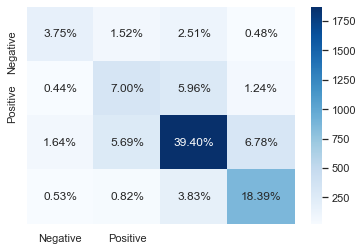

In [71]:
BNBModel = BernoulliNB()
fit_eval_model(BNBModel, X_train_bal,tfidf_X_test)

In [ ]:
BNB_comet = BernoulliNB()
BNB_comet.fit(tfidf_X_train,y_train)
y_pred = BNB_comet.predict(tfidf_X_test)

In [ ]:
f1 = f1_score(y_test, y_pred, average = 'weighted')
precision = precision_score(y_test, y_pred, average = 'weighted', zero_division = 1)
recall = recall_score(y_test, y_pred, average = 'weighted')
confusion = confusion_matrix(y_test, y_pred)
confusion

In [ ]:
params = {"test_size": 0.3,
          "model_type": "Bernoulli-Naive_Bayes",
          "vectorizer": "tfidf vectorizer",
          "param_grid": "None" ,
          "stratify": True
          }
metrics = {"f1 score": f1,
           "recall matrix": recall,
           "precision matrix": precision,
           'confusion matrix': confusion
           }

In [ ]:
experiment.log_parameters(params)
experiment.log_metrics(metrics)

In [ ]:
experiment.end()

#### Model Development

#### Model Performance Metrics

#### Test Dataset Prediction Metrics

### XG Boost Classification

#### Model Development

#### Model Performance Metrics

#### Test Dataset Prediction Metrics

### Hyper Parameter Tuning

## Model Performance Comparison

### Functions Declaration

## Model Explanation

## Conclusion

## Appendix

### Kaggle Submission

#### Functions Declaration

In [124]:
#feed in preprocessing
#def preprocessing(df):
    return df

# def predict_model(model, df):
#    transforms to a df     
#     return predictions


test_df['message'] = test_df['message'].apply(lambda txt:SpellChecker().correction(txt))

In [81]:
test_df['message']=test_df['message'].apply(lambda x: re.sub('\w*\d\w*','', x))
test_df['message']=test_df['message'].apply(lambda x:expand_contractions(x))
test_df['message']=test_df['message'].apply(lambda x: x.lower())
test_df['message']=test_df['message'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
test_df['message'] = test_df['message'].apply(stemmer) 

In [82]:
test_tweets = test_df['message']

In [83]:
tfidf_X_test = tfidf_vectorizer.transform(test_tweets)

In [84]:
test_pred = BNBModel.predict(tfidf_X_test)

#### Submission Metrics

In [ ]:
#feed in model

#def submission(model, df)

In [85]:
###
sub_id = test_df['tweetid'].to_list()
sub_pred = test_pred.tolist()
list_of_tuples = list(zip(sub_id, sub_pred))
submission_df = pd.DataFrame(list_of_tuples,
                  columns = ['tweetid', 'sentiment'])
submission_df.set_index('tweetid', inplace=True)

In [86]:
submission_df['sentiment'].value_counts()

 1    5336
 2    2888
 0    1571
-1     751
Name: sentiment, dtype: int64

submission_df.to_csv('280322_Cleaned_Vectorizer_Submission.csv') #score of 0.700

submission_df.to_csv('290322_Lemmatized_stemmd_Vectorizer_Submission.csv') #score of 0.68